# Now just using DF directly
## no longer need to parse separately into lists etc.  all done internally
## TO Do the dump load and initialize the DB, need to make sure correct order pf tables is loaded first those with no dependencies and then increasingly so.
## now only erroring on original 3 .txt noted by Ian Gorton in original commnication
- - 1. Conf
- - 2. Pub , Keys, Authors, Affiliations (use sets to create unique ones but may change to all .unique)
- - 3. Composites (Many to Many)
- - 4. Paper/abstracts



In [4]:
import sqlite3
import pandas as pd

In [5]:
import sqlcommands as cmd
cmd = reload(cmd)

(1548, 7)


In [6]:
df = cmd.createTOTALTable()
df.iloc[50:60]

/Users/aileennovero1/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1160: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


,Abstract,Author affiliation,Authors,Conf,Title,terms,year
50,The past 20 years has seen significant investm...,"IBM Software Group, Raleigh, NC, United States...","['Brown, Alan W', '', '', ' McDermid, John A',...",ECSA,The art and science of software architecture,"['Failure analysis', 'Systems engineering', 'O...",2007
51,"Nowadays, Wireless Sensor Networks WSN are a...",Divisi n de Sistemas e Ingenier a Electr nica ...,"['Losilla, Fernando', '', '', 'Vicente Chicote...",ECSA,Wireless sensor network application developmen...,"['Mathematical models', 'Software architecture...",2007
52,Automated services help enterprises create new...,"INFOLAB, Tilburg University, Dept of Informat...","['Papazoglou, Michael P', '', '']",ECSA,What s in a service,"['Condition monitoring', 'Electronic commerce'...",2007
53,The term co evolution describes the symbiotic ...,"University of St Andrews, St Andrews, KY16 9SX...","['Morrison, Ron', '', '', 'Balasubramaniam, Dh...",ECSA,An active architecture approach to dynamic sys...,"['Dynamical systems', 'Grid computing', 'Senso...",2007
54,Software architecture views represent the basi...,Department of Information Systems and Computat...,"['Cordero, Rogelio Limon', '', '', 'Salavert, ...",ECSA,Analyzing styles of the modular software archi...,"['Computer aided design', 'Requirements engine...",2007
55,"Currently, most software systems have a dynami...",Department of Information Systems and Computat...,"['Costa, Crist bal', '', '', 'Ali, Nour', '', ...",ECSA,Dynamic reconfiguration of software architectu...,"['Computer aided design', 'Object oriented pro...",2007
56,We propose a pattern based software developmen...,Department of Computational and Cognitive Scie...,"['C t , Isabelle', '', '', 'Heisel, Marina', '...",ECSA,Pattern based evolution of software architectures,"['Pattern recognition', 'Requirements engineer...",2007
57,Most of the research in the area of multimodal...,"Department of Computer Science, Technische Uni...","['Pereira, Alessandro Costa', ' ,', '', ' Hart...",ECSA,A distributed staged architecture for multimod...,"['Computer programming languages', 'Distribute...",2007
58,The vast diversity of implementation and suppo...,"Computer Languages and Systems II Department, ...","['L pez Sanz, Marcos', '', '', 'Acu a, C sar J...",ECSA,UML profile for the platform independent model...,"['Computer simulation', 'Computer software por...",2007
59,No abstract available,None,"['Dauvin, Jean Claude', ' Romana, Louis Alexan...",ECSA,Hydrobiologia Preface,[nan],2007


In [7]:
#don't need 
#df1 = cmd.getPatentDataFrame(hdffile='../DataBaseParsing/DFstore4.h5') 

In [8]:
df.iloc[0]['Author affiliation']

u'DISP, Univ  of Rome, Rome, Italy'

# Create the Conf Table

In [9]:
confDF = cmd.createConfTable(df)

Opened Abstracts_DB.db database successfully
Created DataFrame
Records created successfully


In [10]:
confDF.head()

,confID,confName
0,1,ECSA
1,2,QoSA
2,3,WICSA


# Create publications Table
## Now can parse all the orginal .txt with exception of the same 3  Ian gorton noted were errant

In [11]:
pubDF = cmd.createPublicationsTable(df)

Opened Abstracts_DB.db database successfully
table dropped
Created PUBLICATIONS table
Created DataFrame
Records created successfully


In [12]:
pubDF.head()
#pubDF.to_csv('Tables_v1/publications.csv', sheet_name = 'publications')

,pubID,year,confName
0,1,2007,ECSA
1,2,2008,ECSA
2,3,2009,ECSA
3,4,2010,ECSA
4,5,2011,ECSA


# Create Keys Table

## There are errors here and I have spent way to ong trying to figure if out.  
## Somewhere the abstracts are being split into the terms.

In [13]:
keys = cmd.createKEYSTable(df)

Opened Abstracts_DB.db database successfully
              keyword
0     Loose couplings
1   aspectual concept
2       Discrete time
3  Polyacrylonitriles
4     Tacit knowledge
Created DataFrame
Records created successfully


In [14]:
print len(keys)
print len(keys.keyword.unique())
keys.iloc[50:75]
keys.head(20)

8399
8399


,keyID,keyword
0,1,Loose couplings
1,2,aspectual concept
2,3,Discrete time
3,4,Polyacrylonitriles
4,5,Tacit knowledge
5,6,microphytobenthos)
6,7,centered around the Spectrum Access System (SA...
7,8,Radiation Measuring Instruments
8,9,advanced communication technology
9,10,Automotive companies


# Authors
## I don't know how to parse them better!  Each text file seems to look at them differently and no idea what to do

In [15]:
authorsDF = cmd.createAUTHORSTable(df)

Opened Abstracts_DB.db database successfully
Author set created
Records created successfully


In [16]:
print len(authorsDF.authorName.drop_duplicates())  #<<--- double check!  will keep one 'empty ' ' becuase of set)
authorsDF.head()

2911


,authorID,authorName
0,1,Kolb Ronny
1,2,Von Massow Robert
2,3,Smiley Karen
3,4,Prakash Jai
4,5,Zhang Hongye


# Affiliation Table
## simple no extra parsing do to differences between entries

In [17]:
affilDF= cmd.createAFFILIATIONTable(df)

Opened Abstracts_DB.db database successfully
Created DataFrame
Records created successfully


In [18]:
affilDF.head()
#affilDF.to_csv('Tables_v1/affiliations.csv', sheet_name = 'affilations')

,affilID,affiliation
0,1,"DISP, Univ of Rome, Rome, Italy"
1,2,"LSTS ENIT, Tunis, Tunisia"
2,3,"INRIA, Univ des Sci et Technol de Lille, Vi..."
3,4,"Sch of Comput Sci , Univ of Adelaide, Adela..."
4,5,"Software Group, IBM, Raleigh, NC, United States"


# PAPER TABLE
## should this actually be made by first doing a join or something with the pub table?

In [19]:
paperDF= cmd.createPAPERTable(df)

Opened Abstracts_DB.db database successfully
table dropped
Created PAPER table
Created DataFrame
Records created successfully


In [20]:
paperDF.iloc[0].terms

u"['Software design', 'Structural properties', 'Feature models', 'Product-lines', 'Research challenges', 'Software product line architecture', 'Software product lines', 'Software systems', 'Structural Design', 'Computer Programming', 'Materials Science']"

In [21]:
mydb = 'Abstracts_DB.db'
#paperDF.to_csv('Tables_v1/paper.csv', sheet_name = 'paper')
paperDFbyYrandConf = paperDF[['pubYear', 'confName', 'paperID']].groupby(['pubYear', 'confName'], axis = 0)
#paperDFbyYrandConf.count().to_html()
paperDFbyYrandConf.get_group((2007, 'ECSA'))

,pubYear,confName,paperID
20,2007,ECSA,21
68,2007,ECSA,69
76,2007,ECSA,77
78,2007,ECSA,79
84,2007,ECSA,85
86,2007,ECSA,87
120,2007,ECSA,121
130,2007,ECSA,131
132,2007,ECSA,133
143,2007,ECSA,144


In [22]:
def getPapersConfYr(yr, conf):
    with sqlite3.connect(mydb) as con:
        sqlcmd = "SELECT pubYear, confName, paperID, title, abstract FROM PAPER"
        PAPdf = pd.read_sql_query(sqlcmd, con)
    
        group = PAPdf.groupby(['pubYear', 'confName'], axis = 0)
        subgrp = group.get_group((yr, conf))
        
        return subgrp

In [23]:
y = getPapersConfYr(2004, 'WICSA')
y.index

Int64Index([   8,    9,   32,   33,   36,   60,   61,  134,  135,  193,  194,
             217,  236,  238,  239,  247,  248,  317,  318,  320,  321,  348,
             349,  446,  447,  489,  490,  499,  500,  533,  534,  542,  543,
             648,  649,  730,  731,  805,  806,  883,  884,  893,  894,  966,
             967, 1144, 1145, 1201, 1202, 1245, 1246, 1256, 1257, 1263, 1264,
            1271, 1272, 1338, 1339, 1347, 1348, 1352, 1353, 1406, 1407, 1413,
            1414, 1478, 1479],
           dtype='int64')

In [24]:
mytable = []
for idx in y.index.get_values():
    entry = {}
    entry['paperID'] = y.loc[idx]['paperID']
    entry['title'] = y.loc[idx]['title']
    entry['abstract'] = y.loc[idx]['abstract']
    mytable.append(entry)
x = dict(data = mytable)
    

In [25]:
x

{'data': [{'abstract': u'A common approach to adding self management capabilities to a system is to provide one or more external control modules, whose responsibility is to monitor system behavior, and adapt the system at run time to achieve various goals  configure the system, improve performance, recover from faults, etc    An important problem arises when there is more than one such self management module  how can one make sure that they are composed to provide consistent and complementary benefits  In this paper we describe a solution that introduces a self management coordination architecture and infrastructure to support such composition  We focus on the problem of coordinating self configuring and self healing capabilities, particularly with respect to global configuration and incremental repair  We illustrate the approach in the context of a self managing video teleconference system that composes two pre existing adaptation modules to achieve synergistic benefits of both   28 r

# PAPERKEY COMPOSITE

In [54]:
pk = cmd.createPAPERKEYTable(paperDF)

Opened Abstracts_DB.db database successfully
Records created successfully


In [55]:
pk.head()

,paperID,keyword
0,1,u'Research challenges'
1,1,u'Software product line architecture'
2,1,u'Materials Science'
3,1,u'Structural properties'
4,1,u'Software product lines'


In [56]:
pk.tail()

,paperID,keyword
25672,1486,u'Carbon corrosion'
25673,1486,u'Chemical Products Generally'
25674,1486,u'Optical Devices and Systems'
25675,1486,u'Fuel cells'
25676,1486,u'Transmission electron microscopy'


In [71]:
paperKey = pk.merge(paperDF[['paperID', 'title','confName', 'pubYear']], on = 'paperID')
paperKey.head()

,paperID,keyword,title,confName,pubYear
0,1,u'Research challenges',On the need of safe software product line arch...,ECSA,2010
1,1,u'Software product line architecture',On the need of safe software product line arch...,ECSA,2010
2,1,u'Materials Science',On the need of safe software product line arch...,ECSA,2010
3,1,u'Structural properties',On the need of safe software product line arch...,ECSA,2010
4,1,u'Software product lines',On the need of safe software product line arch...,ECSA,2010


In [72]:
def getPapersKWgroup(grouper):
    with sqlite3.connect('Abstracts_DB.db') as con:
        sqlcmd = "SELECT paperID, title, confName, pubYear FROM PAPER "
        paperdf = pd.read_sql_query(sqlcmd, con)
        sqlcmd2 = "SELECT paperID, keyword FROM PAPERKEY "
        kwdf = pd.read_sql_query(sqlcmd2, con)
        
        merged = kwdf.merge(paperdf, on = 'paperID')
        
        subgrp = merged.groupby(grouper)
        
        return subgrp

In [61]:
paperKeyword = paperKey.groupby('paperID').count()
paperKwYr = paperKey.groupby('pubYear')

In [62]:
paperKwYr.get_group(2010)[['paperID', 'keyword']].groupby('keyword').count().sort('paperID', ascending = False)  

/Users/aileennovero1/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,paperID
keyword,
u'Data Handling and Applications',63
u'Computer Programming',60
u'Computer Software',58
u'Technical presentations',51
u'Information Dissemination',48
u'Software architecture',25
u'Computer software selection and evaluation',19
u'Computer Applications',19
u'Fuel Cells',17


/Users/aileennovero1/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


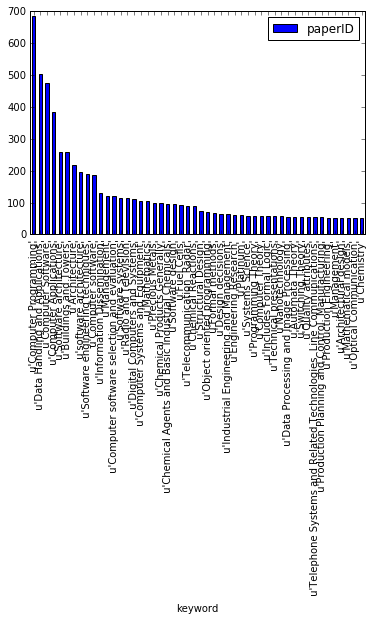

In [37]:
#KeywordFreq[:50].plot(kind = 'bar', x = 'keyword', y = 'paperID')
##broken down by conferences and years...  (enter a keyword and see trend over conference and year.

##top keywords(cts?) for given conference over the years.

##compare the confernces - given two conferences display their top keywords for a given year

##do same for authors and what conferences.

##top 20 authors and their keywords, conferences, trends over time.


In [73]:
#enter a keyword and see trend over conference and year.
try1 = paperKey
try1['keyword'] = try1['keyword'].apply(lambda word : eval(word))
try1.head()

,paperID,keyword,title,confName,pubYear
0,1,Research challenges,On the need of safe software product line arch...,ECSA,2010
1,1,Software product line architecture,On the need of safe software product line arch...,ECSA,2010
2,1,Materials Science,On the need of safe software product line arch...,ECSA,2010
3,1,Structural properties,On the need of safe software product line arch...,ECSA,2010
4,1,Software product lines,On the need of safe software product line arch...,ECSA,2010


In [74]:
KeywordFreq = try1.groupby('keyword')


In [77]:
KeywordFreq.get_group('aspectual concept')

,paperID,keyword,title,confName,pubYear
25311,1461,aspectual concept,AspectLEDA extending an ADL with aspectual co...,ECSA,2007
25324,1462,aspectual concept,AspectLEDA extending an ADL with aspectual co...,ECSA,2008


# Affiliation_Paper Composite 
## necessary?

In [ ]:
paperAffiliationDF = cmd.createAFFILIATIONPAPERTable(paperDF, affilDF)

In [ ]:
paperAffiliationDF.tail()
#paperAffiliationDF.to_csv('Tables_v1/paperAffiliation.csv', sheet_name = 'paperAffil')

In [ ]:
paperDF[['paperID', 'pubYear']].merge(paperAffiliationDF, on = 'paperID').tail()

# PAPERAUTHORS COMPOSITE

In [ ]:
authorPaper = cmd.createPAPERAUTHORTable(paperDF[['paperID', 'authors']])
#authorPaper.to_csv('Tables_v1/authorPaper.csv', sheet_name = 'paperAuthor')

In [ ]:
authorPaper.head(20)

In [ ]:
paperDF[['paperID', 'title']].merge(authorPaper, on = 'paperID').head(20)

In [ ]:
from flask import *

In [ ]:
confDF.to_html()

In [ ]:
confDF.plot(kind = 'box')

In [ ]:
%matplotlib inline

Queries:
As for the given queries: 
papers with key word grouped by year.   
- PaperID ---> KeywordFK, PaperID --> PublicationID:year

author's most buzzy words : 
- authorID ---> paperID -->KeyWordId (count) (sort).max

paper's affiliation grouped by conference and year  ??
- paper ID:affiliation ---> publicationID:year -->ConferenceID:type

conference/year and the keywords in order of frequency (ie word cloud visualization maybe?)  <<_--this might break it?
- confID -->publicationID --> PaperIDs-->KeywordIDs (count) (sort descending)

Affiliation's authors
- authorsID--: papersIds: affiliation  (i need to check if an author can have multiple affiliations, I can't see why not if they change universities or companies after 10 years)


Most frequent affiliations per conference
paperIDs: affiliation --> publicationIDs --> ConferenceID

In [ ]:
q1 = pk.merge(paperDF[['paperID', 'pubYear']], on = 'paperID')


In [ ]:
len(q1['keyword'].unique())

In [ ]:
len(authorPaper)

In [ ]:
authorAffiliation = authorPaper.merge(paperDF[['paperID', 'affiliation', 'pubYear']])

In [ ]:
authorAffiliation.query('"Muccini, Henry" in authorName').sort('pubYear')

In [ ]:
#paper's affiliation grouped by conference and year ??
papafiil = paperAffiliationDF.merge(paperDF[['paperID', 'pubYear', 'confName']], on = 'paperID')

In [ ]:
groupPA = papafiil.groupby(['pubYear', 'confName'])

In [ ]:
groupPA.aggregate('count')

In [ ]:
conf